# I. - Preface

Nama: Muhammad Fariz Firdaus

Batch: SBY002

Objective: The goal of this project is to make a model that can predict a category of a news article. By building this model, I hope it can help an online news company to categorize their news articles.

# II. Libraries

In [1]:
# Data manipulation libraries
import pandas as pd 
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

# Warning handling
import warnings
warnings.filterwarnings('ignore') #turn off warning

# Text preprocessing libraries
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# ML/DL libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape, SimpleRNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow_hub as tf_hub
from keras.models import load_model
from keras.utils import custom_object_scope
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FARIS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FARIS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FARIS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# III. Data Loading

## 1 - Dataset Information

The dataset I'm using in this project is a public BBC news dataset that was published as [BBC News Classification Competitions](https://www.kaggle.com/competitions/learn-ai-bbc/overview) in Kaggle. The dataset contains 2225 news articles that was labeled into 5 news categories: business, entertainment, politics, sport or tech.

## 2 - Import Data Into Pandas Dataframe

In [2]:
X_train = pd.read_csv('BBC News Train.csv')
X_test = pd.read_csv('BBC News Test.csv')
y_test = pd.read_csv('BBC News Sample Solution.csv')

Check the data.

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


No missing data.

In [4]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


No missing data.

In [5]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Category   735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


No missing data.

for EDA purpose, I'm going to combine those 3 dataframes.

In [6]:
# merge X_test and y_test on 'ArticleId'
test = X_test.merge(y_test, on='ArticleId')

# concatenate train and test dataframes
df = pd.concat([X_train, test], ignore_index=True)

In [7]:
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [8]:
df.tail()

,ArticleId,Text,Category
2220,1923,eu to probe alitalia state aid the european ...,sport
2221,373,u2 to play at grammy awards show irish rock ba...,tech
2222,1704,sport betting rules in spotlight a group of mp...,business
2223,206,alfa romeos to get gm engines fiat is to sto...,entertainment
2224,471,citizenship event for 18s touted citizenship c...,politics


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  2225 non-null   int64 
 1   Text       2225 non-null   object
 2   Category   2225 non-null   object
dtypes: int64(1), object(2)
memory usage: 52.3+ KB


Combined Sucessfully

In [10]:
df.to_csv('deployment\\combined_news_data.csv')

# IV. Exploratory Data Analysis

## 1 - Category Distribution

<Axes: xlabel='Category'>

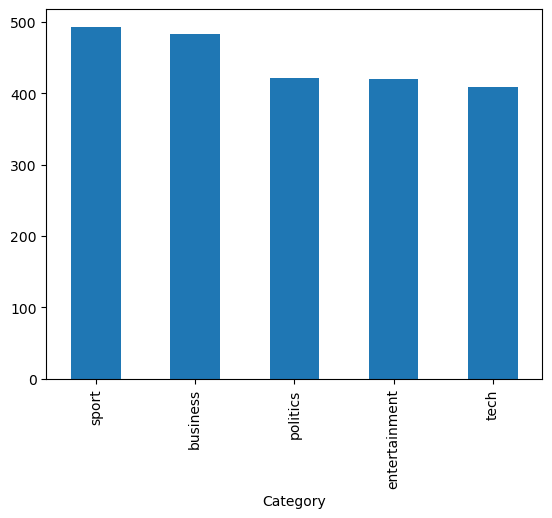

In [11]:
df['Category'].value_counts().plot(kind='bar')

Upon analyzing the distribution across each category, I concluded that the data is relatively balanced. `Sport` has the highest number of articles, while `Tech` has the fewest, with a difference of at most 100 articles.

## 2 - Text Lenght Distribution

In [12]:
# Make a new column called Text Lenght
df['Text_length'] = df['Text'].apply(len)
df.head(10)

,ArticleId,Text,Category,Text_length
0,1833,worldcom ex-boss launches defence lawyers defe...,business,1866
1,154,german business confidence slides german busin...,business,2016
2,1101,bbc poll indicates economic gloom citizens in ...,business,3104
3,1976,lifestyle governs mobile choice faster bett...,tech,3618
4,917,enron bosses in $168m payout eighteen former e...,business,2190
5,1582,howard truanted to play snooker conservative...,politics,1588
6,651,wales silent on grand slam talk rhys williams ...,sport,1988
7,1797,french honour for director parker british film...,entertainment,1342
8,2034,car giant hit by mercedes slump a slump in pro...,business,2609
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,1368


In [13]:
# basic statistics of text length across all articles
print(df['Text_length'].describe())

count     2225.00000
mean      2262.93618
std       1364.10253
min        501.00000
25%       1446.00000
50%       1965.00000
75%       2802.00000
max      25483.00000
Name: Text_length, dtype: float64


On average, an article contains approximately 2,263 words. However, this average can't explain the whole dataset, due to the big variation in the length of the articles, as shown by the standard deviation of 1,364. The shortest article in the dataset is quite short, containing only 501 words, while the longest article is quite long, up to 25,483. Looking at the median of 1,965 words I can conclude that when all the articles are sorted by length, the one in the middle has 1,965 words. Half of the articles are shorter than this, and half are longer. The first quartile, or the 25th percentile, is 1,446 words. This means that a quarter of the articles are shorter than this. On the other hand, the third quartile, or the 75th percentile, is 2,802 words, indicating that three-quarters of the articles are shorter than this.

For better analysis, I can visualize it using boxplot.

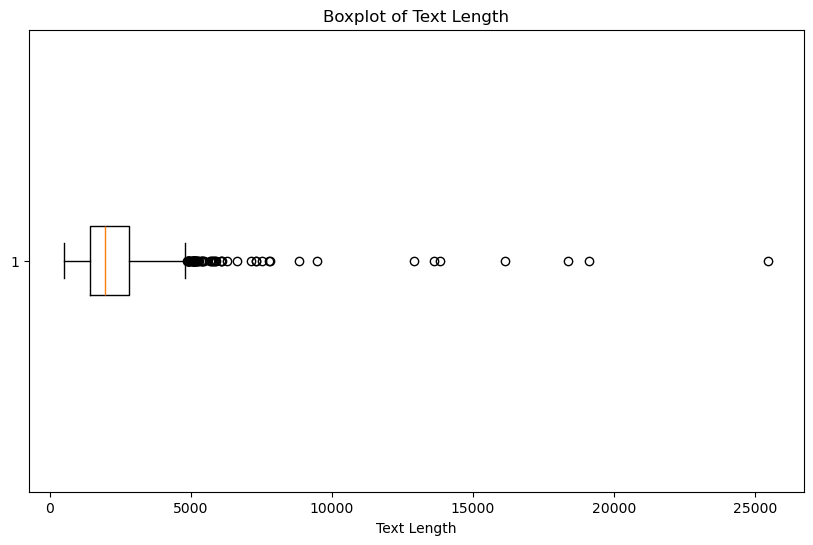

In [14]:
# Create a boxplot of the 'Text_length' column
plt.figure(figsize=(10,6))
plt.boxplot(df['Text_length'], vert=False)
plt.title('Boxplot of Text Length')
plt.xlabel('Text Length')
plt.show()

The lenght of articles are concentrated at around 2000 words, with many and far outliers, up to 25483 words.

# V. Feature Engineering

## 1 - Preprocessing

To minimize the numbers of features created from texts, I will do several preprocessing steps.

In [15]:
def preprocessing(text):
    ''' 
    Preprocessing text by applying lowercasing, normalization, tokenization, stopword removal, and lemmatization
    '''
    # Lowercase the text
    text = text.lower()

    # Normalize the text
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove whitespaces

    # Tokenize the text
    tokens = word_tokenize(text)

    # Get the English stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(['also', 'said', 'would', 'could', 'new', 'one', 'u']) # add some frequent words that won't help the model

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the text
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Combine tokens back into a single string
    text = ' '.join(tokens)

    return text

# Apply the function to the 'Text' column in the data
df['Text'] = df['Text'].apply(preprocessing)

In [16]:
df.head()

,ArticleId,Text,Category,Text_length
0,1833,worldcom exboss launch defence lawyer defendin...,business,1866
1,154,german business confidence slide german busine...,business,2016
2,1101,bbc poll indicates economic gloom citizen majo...,business,3104
3,1976,lifestyle governs mobile choice faster better ...,tech,3618
4,917,enron boss payout eighteen former enron direct...,business,2190


Text are preprocessed.

## 2 - Target Conversion into Numbers

In [17]:
# Display Target
df.Category.unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

There's 5 news categories.

In [18]:
# Change Target into Number
df['label'] = df['Category'].replace({'business' : 0, 'tech' : 1, 'politics' : 2, 'sport' : 3, 'entertainment' : 4})

In [19]:
df.head()

,ArticleId,Text,Category,Text_length,label
0,1833,worldcom exboss launch defence lawyer defendin...,business,1866,0
1,154,german business confidence slide german busine...,business,2016,0
2,1101,bbc poll indicates economic gloom citizen majo...,business,3104,0
3,1976,lifestyle governs mobile choice faster better ...,tech,3618,1
4,917,enron boss payout eighteen former enron direct...,business,2190,0


Target converted into numbers.

## 3 - Data Splitting

In [20]:
# split into train+val and test 
X_train_val, X_test, y_train_val, y_test = train_test_split(df.Text,
                                                    df.label,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=df.label)

# split into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                y_train_val,
                                                test_size=0.15,
                                                random_state=42,
                                                stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (1513,)
Val Size   :  (267,)
Test Size  :  (445,)


Data split into train, val and test.

## 4 - Encode target

I'm using one hot encoder to encode labels.

In [21]:
# Change Target to One Hot Encoding
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

# VI. Model Definition and Training

## 1 - Vectorizing and Embedding Layers

I'm using both keras vectorizer and embedding, because they're trained along with the model, and is guided by the loss function.

### 1.1 - Data Vectorizing

First, I need to know the Number of Vocabs and Max Token Length in One Document

In [22]:
# Create a CountVectorizer instance
Vectorize = CountVectorizer()

# Fit and transform the training data
X_train_vec = Vectorize.fit_transform(X_train)

# Transform the val data using the same vocabulary as the training data
X_val_vec = Vectorize.transform(X_test)

# Transform the test data using the same vocabulary as the training data
X_test_vec = Vectorize.transform(X_test)

# Get the total number of unique words in the vocabulary
total_vocab = len(Vectorize.vocabulary_.keys())

# Find the maximum sentence length in terms of tokens in the training set
max_sen_len = max([len(i.split(" ")) for i in X_train])

# Display the total vocabulary and maximum sentence length
print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  23136
Maximum Sentence Length :  2131 tokens


Now that I know the Number of Vocabs and Max Token Length I will create a vectorizer layer for the model.

In [23]:
# Create a TextVectorization layer
text_vectorization = TextVectorization(
    max_tokens=total_vocab,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None,
    output_mode="int",
    output_sequence_length=max_sen_len,
    input_shape=(1,)  # Only used in Sequential API
)

# Adapt the TextVectorization layer to the training data
text_vectorization.adapt(X_train)

### 1.2 - Word Embedding

In [24]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                    output_dim=128,
                    embeddings_initializer="uniform",
                    input_length=max_sen_len)

For word embedding, I'm using Embedding from keras, as it's good enough for this case.

## 1 - RNN

In [25]:
## Clear Session
seed = 42
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [26]:
# Define the architecture
model_rnn = Sequential()
model_rnn.add(text_vectorization)
model_rnn.add(embedding)
model_rnn.add(Bidirectional(SimpleRNN(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_rnn.add(Bidirectional(SimpleRNN(16, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_rnn.add(Bidirectional(SimpleRNN(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_rnn.add(Dense(5, activation='softmax'))

model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')


In [27]:
print(model_rnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 2131)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 2131, 128)         2961408   
                                                                 
 bidirectional (Bidirection  (None, 2131, 64)          10304     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 2131, 32)          2592      
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 16)                656       
 onal)                                                  

In [28]:
model_rnn_hist = model_rnn.fit(X_train, y_train_ohe, epochs=10, validation_data=(X_val, y_val_ohe))

Epoch 1/10


48/48 [==============================] - 63s 1s/step - loss: 1.6217 - accuracy: 0.2267 - val_loss: 1.5712 - val_accuracy: 0.3146
Epoch 2/10
48/48 [==============================] - 59s 1s/step - loss: 1.0673 - accuracy: 0.7640 - val_loss: 1.5617 - val_accuracy: 0.2959
Epoch 3/10
48/48 [==============================] - 64s 1s/step - loss: 0.5661 - accuracy: 0.9630 - val_loss: 1.6123 - val_accuracy: 0.3408
Epoch 4/10
48/48 [==============================] - 62s 1s/step - loss: 0.3510 - accuracy: 0.9755 - val_loss: 1.6613 - val_accuracy: 0.3596
Epoch 5/10
48/48 [==============================] - 61s 1s/step - loss: 0.2511 - accuracy: 0.9775 - val_loss: 1.7594 - val_accuracy: 0.3408
Epoch 6/10
48/48 [==============================] - 60s 1s/step - loss: 0.1976 - accuracy: 0.9775 - val_loss: 1.8101 - val_accuracy: 0.3221
Epoch 7/10
48/48 [==============================] - 60s 1s/step - loss: 0.1586 - accuracy: 0.9762 - val_loss: 1.8844 - val_accuracy: 0.3071
Epoch 8/10
48/48 [=============

Here is the explanation of the architecture created:

1. `Sequential Model`: I'm using Keras Sequential model.

2. `Text Vectorization`: The first layer of my model, it transforms the data into vector format.

3. `Embedding Layer`: This layer turns vectorized data into dense vector (word vector).

4. `Bidirectional SimpleRNN Layers`: I made 3 Bidirectional SimpleRNN layers with 32, 16, and 8 neurons respectively. The `Bidirectional` is used for RNN layers, which means the input forward and backwards through the RNN layer and then concatenates the output. This is common practice in nlp to help the RNN to learn. The `return_sequences=True` argument is used for stacking RNN layers so that the next RNN layer has a three-dimensional sequence input.

5. `Dense Layer`: The final layer is a Dense layer with 5 neurons and a softmax activation function. 5 neurons because there's 5 target classes, and softmax was used as it's the best one for multi class classification case.

6. `Compilation`: Finally, I compile the model with the 'adam' optimizer, 'categorical_crossentropy' as the loss function, and I choose'accuracy' as the performance metric. adam is very simple but efficient, so I used it. 'categorical_crossentropy' is a very suitable loss function for my case. as for accuracy, it was choosen as the data has a balanced distribution

## 2 - LSTM

In [29]:
## Clear Session
seed = 42
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [30]:
# Define the architecture
model_lstm = Sequential()
model_lstm.add(text_vectorization)
model_lstm.add(embedding)
model_lstm.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm.add(Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm.add(Bidirectional(LSTM(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm.add(Dense(5, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [31]:
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 2131)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 2131, 128)         2961408   
                                                                 
 bidirectional (Bidirection  (None, 2131, 64)          41216     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 2131, 32)          10368     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 16)                2624      
 onal)                                                  

In [32]:
model_lstm_hist = model_lstm.fit(X_train, y_train_ohe, epochs=10, validation_data=(X_val, y_val_ohe))

Epoch 1/10
48/48 [==============================] - 120s 2s/step - loss: 1.5554 - accuracy: 0.3232 - val_loss: 1.4451 - val_accuracy: 0.5019
Epoch 2/10
48/48 [==============================] - 69s 1s/step - loss: 1.2187 - accuracy: 0.6312 - val_loss: 1.2326 - val_accuracy: 0.5730
Epoch 3/10
48/48 [==============================] - 76s 2s/step - loss: 0.8773 - accuracy: 0.8011 - val_loss: 1.2594 - val_accuracy: 0.5581
Epoch 4/10
48/48 [==============================] - 68s 1s/step - loss: 0.6084 - accuracy: 0.8896 - val_loss: 1.2950 - val_accuracy: 0.5693
Epoch 5/10
48/48 [==============================] - 68s 1s/step - loss: 0.4564 - accuracy: 0.9061 - val_loss: 1.3491 - val_accuracy: 0.5393
Epoch 6/10
48/48 [==============================] - 67s 1s/step - loss: 0.3426 - accuracy: 0.9359 - val_loss: 1.4317 - val_accuracy: 0.5206
Epoch 7/10
48/48 [==============================] - 70s 1s/step - loss: 0.2628 - accuracy: 0.9504 - val_loss: 1.4978 - val_accuracy: 0.5393
Epoch 8/10
48/48 [=

The model has similar architecture as the previous one, the only difference is in RNN layers I'm using LSTM instead of SimpleRNN to compare their performance.

## 3 - GRU

In [33]:
## Clear Session
seed = 42
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [34]:
# Define the architecture
model_gru = Sequential()
model_gru.add(text_vectorization)
model_gru.add(embedding)
model_gru.add(Bidirectional(GRU(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru.add(Bidirectional(GRU(16, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru.add(Bidirectional(GRU(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru.add(Dense(5, activation='softmax'))

model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [35]:
print(model_gru.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 2131)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 2131, 128)         2961408   
                                                                 
 bidirectional (Bidirection  (None, 2131, 64)          31104     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 2131, 32)          7872      
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 16)                2016      
 onal)                                                  

In [36]:
model_gru_hist = model_gru.fit(X_train, y_train_ohe, epochs=10, validation_data=(X_val, y_val_ohe))

Epoch 1/10


48/48 [==============================] - 81s 2s/step - loss: 1.3746 - accuracy: 0.5420 - val_loss: 1.3857 - val_accuracy: 0.4794
Epoch 2/10
48/48 [==============================] - 70s 1s/step - loss: 0.7669 - accuracy: 0.7845 - val_loss: 1.4308 - val_accuracy: 0.4794
Epoch 3/10
48/48 [==============================] - 71s 1s/step - loss: 0.5287 - accuracy: 0.9068 - val_loss: 1.5259 - val_accuracy: 0.4794
Epoch 4/10
48/48 [==============================] - 72s 1s/step - loss: 0.3965 - accuracy: 0.9551 - val_loss: 1.6661 - val_accuracy: 0.4794
Epoch 5/10
48/48 [==============================] - 72s 2s/step - loss: 0.3204 - accuracy: 0.9603 - val_loss: 1.7251 - val_accuracy: 0.4719
Epoch 6/10
48/48 [==============================] - 71s 1s/step - loss: 0.2741 - accuracy: 0.9650 - val_loss: 1.7986 - val_accuracy: 0.4757
Epoch 7/10
48/48 [==============================] - 71s 1s/step - loss: 0.2375 - accuracy: 0.9703 - val_loss: 1.8487 - val_accuracy: 0.4569
Epoch 8/10
48/48 [=============

The model has similar architecture as the previous ones, the only difference is in RNN layers I'm using GRU instead to compare their performance.

# VII. Model Evaluation

## 1 - RNN

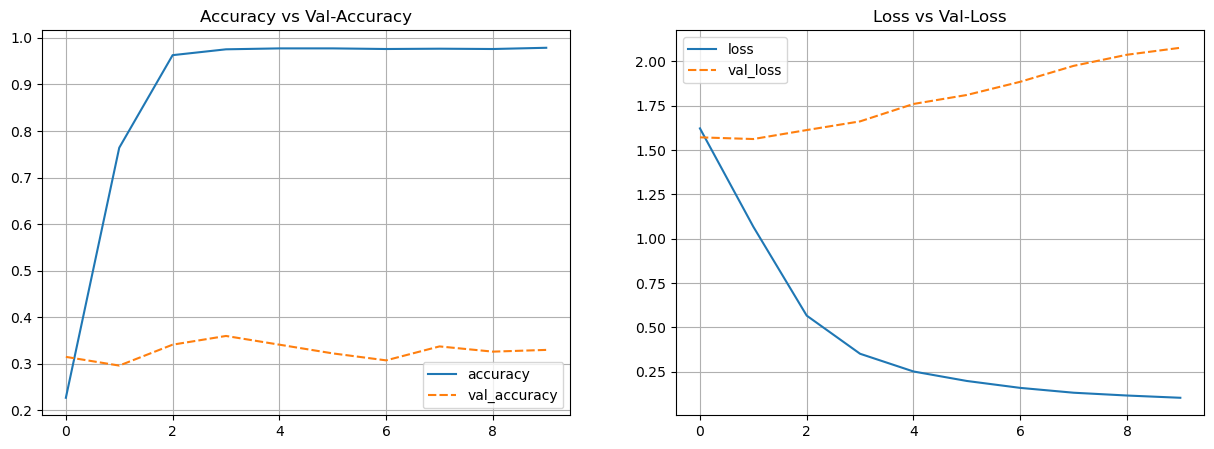

In [37]:
# Plot Training Results

model_rnn_hist_df = pd.DataFrame(model_rnn_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_rnn_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_rnn_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

The SimpleRNN model shows a very overfitted model. The validation accuracy is very low, and stagnant too.

## 2 - LSTM

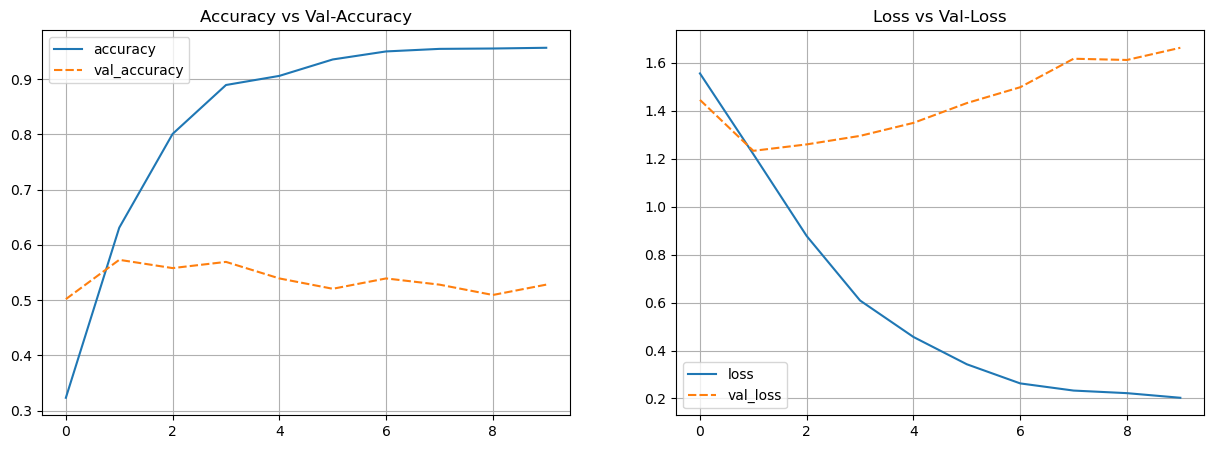

In [38]:
# Plot Training Results

model_lstm_hist_df = pd.DataFrame(model_lstm_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

The model created is very ovitted too, but it has relatively higher accuracy, so I'll consider this as the best base model to be improved later.

## 3 - GRU

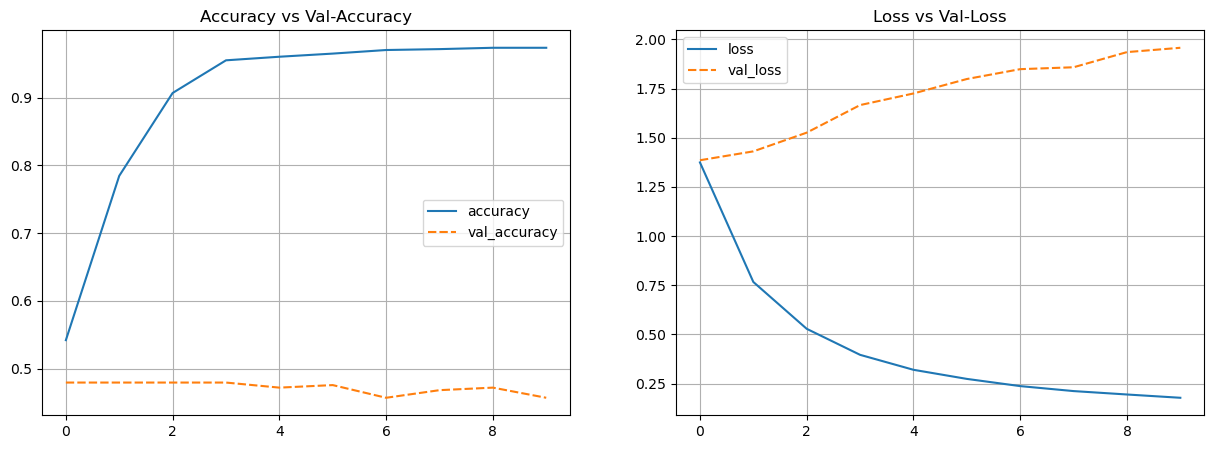

In [39]:
# Plot Training Results

model_gru_hist_df = pd.DataFrame(model_gru_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_gru_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_gru_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

The model is very overfitted too, with low and stagnat validation accuracy.

# VIII. Model Improvement

In [25]:
# Download the Embedding Layer

url = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [26]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [27]:
# Model Training using LSTM with Transfer Learning

## Define the architecture
model_LSTM_2 = Sequential()
model_LSTM_2.add(hub_layer)
model_LSTM_2.add(Reshape((128, 1)))
model_LSTM_2.add(Bidirectional(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_LSTM_2.add(Dropout(0.5))
model_LSTM_2.add(Bidirectional(LSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_LSTM_2.add(Dropout(0.5))
model_LSTM_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_LSTM_2.add(Dropout(0.5))
model_LSTM_2.add(Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_LSTM_2.add(Dropout(0.5))
model_LSTM_2.add(Bidirectional(LSTM(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_LSTM_2.add(Dropout(0.5))
model_LSTM_2.add(Dense(5, activation='softmax'))

model_LSTM_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [28]:
print(model_LSTM_2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 bidirectional (Bidirection  (None, 128, 256)          133120    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128, 128)          164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0

Here are the list of improvements I've made on this model:

1. `Transfer Learning`: I've implemented transfer learning by using a pre-trained embedding layer from TensorFlow Hub. As this layer was made by google using their news dataset, I assume it can help model to gain better performance as these embeddings are more expressive than the ones learned from scratch.

2. `Model Checkpoint`: I've added an ModelCheckpoint callback to my new model training. This will save the best state of model in every epoch, meaning that I can save the model on their best state to choose instead of the latest one.

3. `Dropout Layer`: To reduce overfitting, I'm applying dropout layer on the architecture. Dropout of 0.5 means approximately 0.5 of the inputs will be randomly excluded from each update cycle, Which is very strict.

3. `Increase Number of Layers`: To make model more complicated and learn more pattern, I'm increasing the number of layers as improvement. (to increase accuracy)

4. `Increase Epoch`: The previous models only use 10 epochs, I beleive it's not enough to completely capture the pattern in the model. I'm using 50 epochs for this model.

By using transfer learning I hope it gives my model a better chance of finding patterns in my data. As for early stopping, it will help me prevent overfitting.

In [29]:
# Define ModelCheckpoint
model_checkpoint = ModelCheckpoint('deployment\\best_model.h5', monitor='val_loss', save_best_only=True)

model_LSTM_2_hist = model_LSTM_2.fit(X_train, y_train_ohe, epochs=75, validation_data=(X_val, y_val_ohe), callbacks=[model_checkpoint])

Epoch 1/75


48/48 [==============================] - 20s 208ms/step - loss: 1.5703 - accuracy: 0.2842 - val_loss: 1.4855 - val_accuracy: 0.3895
Epoch 2/75
48/48 [==============================] - 7s 155ms/step - loss: 1.5750 - accuracy: 0.3047 - val_loss: 1.4815 - val_accuracy: 0.3933
Epoch 3/75
48/48 [==============================] - 7s 154ms/step - loss: 1.4738 - accuracy: 0.4104 - val_loss: 1.3894 - val_accuracy: 0.4569
Epoch 4/75
48/48 [==============================] - 7s 151ms/step - loss: 1.4426 - accuracy: 0.4223 - val_loss: 1.3707 - val_accuracy: 0.4831
Epoch 5/75
48/48 [==============================] - 7s 152ms/step - loss: 1.4177 - accuracy: 0.4362 - val_loss: 1.3297 - val_accuracy: 0.5131
Epoch 6/75
48/48 [==============================] - 7s 138ms/step - loss: 1.3893 - accuracy: 0.4660 - val_loss: 1.3401 - val_accuracy: 0.5131
Epoch 7/75
48/48 [==============================] - 7s 151ms/step - loss: 1.3726 - accuracy: 0.4779 - val_loss: 1.3091 - val_accuracy: 0.4906
Epoch 8/75
48/48

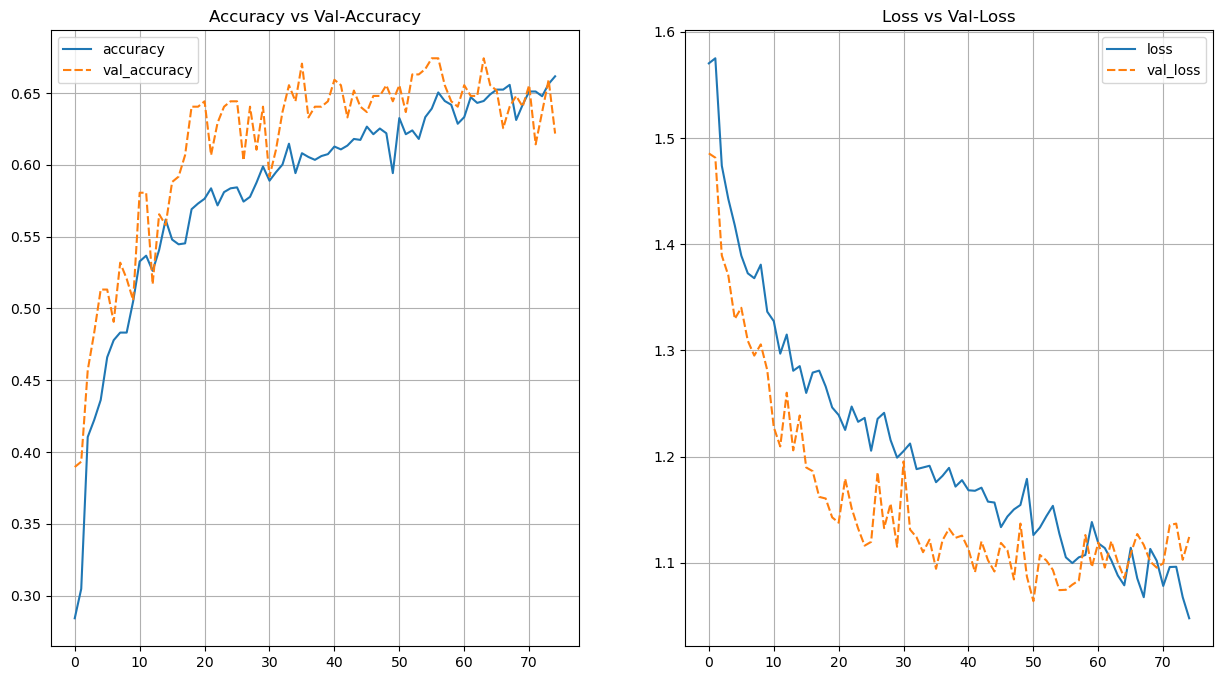

In [30]:
# Plot Training Results

model_LSTM_2_hist_df = pd.DataFrame(model_LSTM_2_hist.history)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_LSTM_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_LSTM_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [33]:
with custom_object_scope({'KerasLayer': tf_hub.KerasLayer}):
    model = load_model('deployment\\best_model.h5')


# Predict the values from the test data
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test observations to one hot vectors
y_true = np.argmax(y_test_ohe, axis = 1)

# compute the confusion matrix
classificationReport = classification_report(y_true, y_pred_classes, target_names = ['business', 'tech', 'politics', 'sport', 'entertainment'])

print('Classification Report')
print(classificationReport)

14/14 [==============================] - 4s 62ms/step
Classification Report
               precision    recall  f1-score   support

     business       0.73      0.62      0.67        96
         tech       0.68      0.65      0.66        82
     politics       0.68      0.62      0.65        84
        sport       0.69      0.81      0.74        99
entertainment       0.56      0.62      0.59        84

     accuracy                           0.67       445
    macro avg       0.67      0.66      0.66       445
 weighted avg       0.67      0.67      0.67       445



The result is a good fit model shown in smooth loss chart. But, it has some spikes in the accuracy and loss chart. The result also shows a higher than baseline accuracy of 67%, but this accuracy can also be considered low, so further improvement might be needed in the future. The resulted model also very fast compared to the base model, which is a good improvement.

# IX. Model Analysis

## 1 - Word Distribution in each Categories

To get the rough idea of how the model works, I'm using wordcloud to visualize the word frequency of words in each categories.

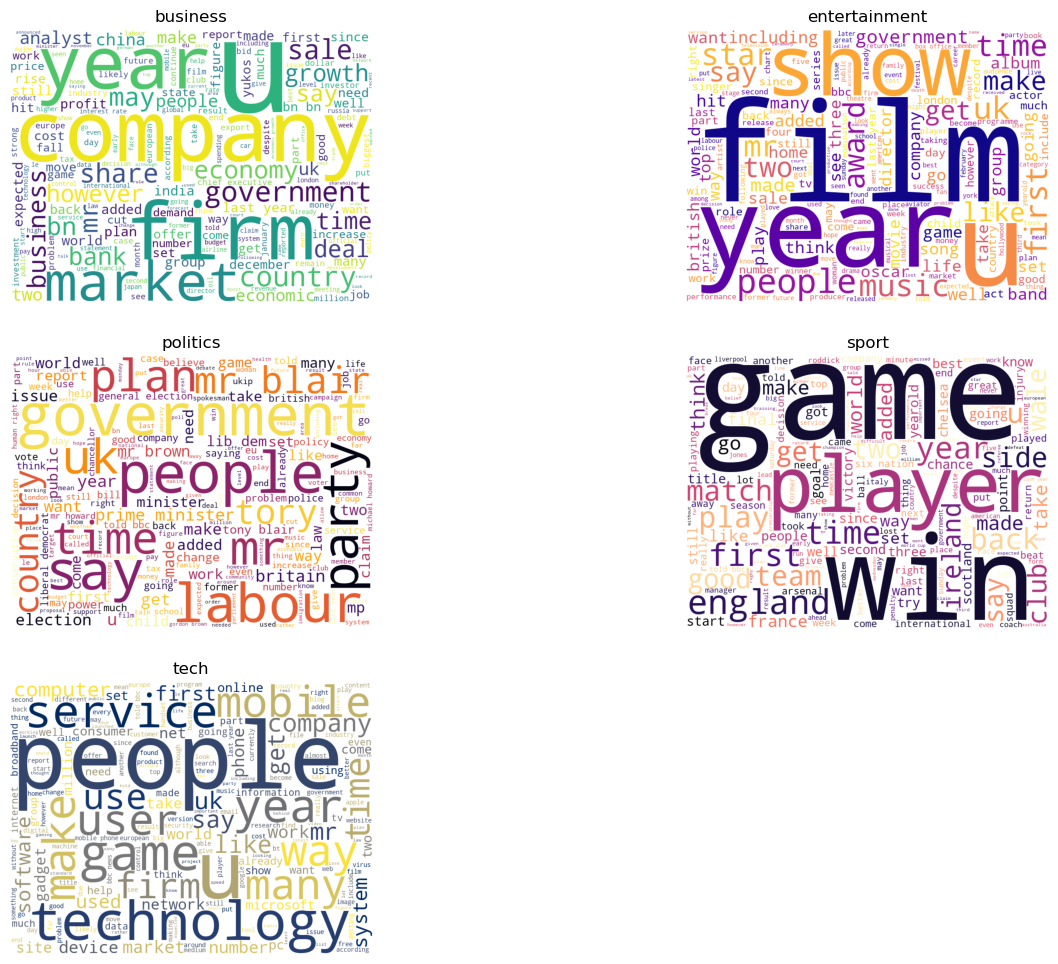

In [47]:
# Group the data by the category column
groups = df.groupby('Category')

# List of colormaps
colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
color = 0

# set the English stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['also', 'said', 'would', 'could'])

# Create a figure
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each category and create a word cloud
for i, (name, group) in enumerate(groups):
    # Get the text data
    text = ' '.join(group['Text'])
    
    # Create a word cloud object
    wc = wordcloud.WordCloud(width=800, height=600, background_color='white', stopwords=stop_words, min_font_size=10, colormap=colormaps[color])
    color += 1
    
    # Generate the word cloud from the text data
    wc.generate(text)
    
    # Plot the word cloud on the subplot
    axes[i].imshow(wc)
    axes[i].set_title(name)
    axes[i].axis('off')

# Remove the unused subplot (if any)
if len(groups) < len(axes):
    fig.delaxes(axes[-1])

# Show the figure
plt.show()

Here are some frequent words in each categories:
1. `bussiness` : Company, Firm, Market
2. `entertainment` : Film, Show, New
3. `politics` : Government, People, Party
4. `sport` : Game, Win, Player
5. `tech` : People, Technology, Mobile

The models might notices these words as a certain pattern. But, at the end we don't really know how the model works.

# X. Model Inference

Model Inference will be done in separate notebook called `P2G7_MuhammadFariz_Inference.ipynb`

# XI. Conclusion

In this project, I was building a news categorization model that uses deep learning in hope of helping a news company that needs their online articles to be sorted based on categories. I was using a dataset in kaggle to train the model, made public by BBC.

I explored the dataset to gain informations about it. I found out that sports is the highest number of category, while tech is the lowest. I also found out that each of them have balanced number of news article amongst them. I also found out that the number of words contained in each articles are very varied.

I created 3 models with similar architecture as the initial solution for this problem. But, I found out that these 3 models are very overfitted, with model that uses LSTM as the hidden layers having the highest number of accuracy.

I decided to do an improvement on that model (LSTM model) by implementing several techniques. The model created have faster training time, higher accuracy, and more stable.

But, I think this new model can still be improved as it only has 67% accuracy. Here are some improvement that might be good to implement on the model:

1. `Increase Dataset Size`: increasing the size of the training dataset might to improvements in model performance. More training data can help the model to learn more patterns.

2. `Data Augmentation`: As alternatives of increasing dataset, applying augmentation can help increase the data. This involves creating new training data by applying transformations to the existing data. For text data, Augmentation can be techniques like sentence shuffling or others.